# Create and run an IMA 'meta' pipeline

### by Patrick Kavanagh (DIAS, Ireland) Jan 27th 2017

This notebook will run through steps of the IMA pipeline (level 2A and 2B) on a single file using a custom pipeline created using the jwst.stpipe Pipeline class. (Note that this is the package on which the standard calibration pipelines are built). This should serve as a useful example of constructing pipelines for testing of new/optimal steps/pipelines

For a description of stpipe see:

http://ssb.stsci.edu/doc/jwst_git/docs/stpipe/html/user/index.html

Information on the pipeline steps can be found here:

http://ssb.stsci.edu/doc/jwst_git/docs/pipeline/html/description.html

The file used in this notebook is a MIRISim simulation of a large galaxy and 500 point sources

#### imports

In [1]:
import os, glob

import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt

#### set the input file

In [2]:
# set filename
input_file = 'det_image_1_MIRIMAGE_F1130Wexp1.fits'

# extract the basename for use in output files
input_basename = os.path.splitext(input_file)[0]

#### print some information about the input file
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

In [3]:
# print some info on input file
with fits.open(input_file) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()
    

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 3	 20	 FAST	 166.5



Filename: det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     136   ()      
  1  SCI         ImageHDU        14   (1032, 1024, 20, 3)   float32   
  2  REFOUT      ImageHDU        14   (258, 1024, 20, 3)   float32   
  3  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF        ImageHDU         7   (322324727,)   uint8   


#### show the last frame of the first integration

No handlers could be found for logger "jwst.datamodels.util"


<IPython.core.display.Javascript object>


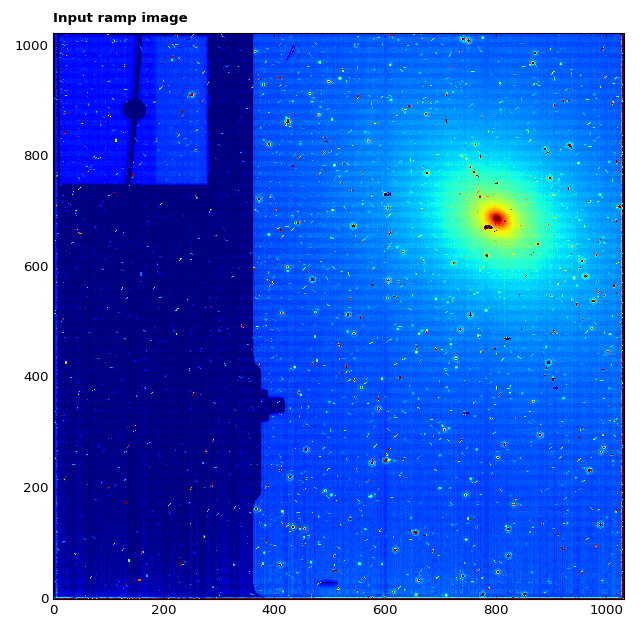

In [4]:
from jwst import datamodels
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(input_file) as in_dm:
        
    # plot--------------------------------------
    # show the input ramp image. Note the user 
    # may need to adjust the scale parameters
    # of the plot
    %matplotlib notebook
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # sum the groups in the first integration of the input ramp image and plot
    axs.imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.02e4,vmax=1.2e4))
    axs.annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs.set_axis_bgcolor('black')

    plt.tight_layout()
    plt.show()

#### set whether to save the output from individual steps, create output directory

In [5]:
# specify if you want to save output from each step:
save_outputs = False

if save_outputs == True:
    # set the name of the output directory
    output_dir = input_basename + '_step-output'

    # if the output directory exists, delete it
    if os.path.exists(output_dir): shutil.rmtree(output_dir)

    # create the output directory
    os.mkdir(output_dir)


### Define our custom pipeline using the stpipe Pipeline class

#### import the stpipe Pipeline class and the datamodels package

In [6]:
from jwst.stpipe import Pipeline
from jwst import datamodels

#### create the 'meta' pipeline called 'MetaMRS'

In [7]:
class MetaIMA(Pipeline):
    """
    'Meta' MRS pipeline comprising all level 2A and 2B pipeline steps
    """

    # step imports
    from jwst.dq_init import dq_init_step
    from jwst.saturation import saturation_step
    from jwst.ipc import ipc_step
    from jwst.linearity import linearity_step
    from jwst.rscd import rscd_step
    from jwst.lastframe import lastframe_step
    from jwst.dark_current import dark_current_step
    from jwst.refpix import refpix_step
    from jwst.persistence import persistence_step
    from jwst.jump import jump_step
    from jwst.ramp_fitting import ramp_fit_step
    from jwst.assign_wcs import assign_wcs_step
    from jwst.flatfield import flat_field_step
    from jwst.photom import photom_step

    # Define aliases to steps
    step_defs = {'dq_init': dq_init_step.DQInitStep,
                 'saturation': saturation_step.SaturationStep,
                 'ipc': ipc_step.IPCStep,
                 'refpix': refpix_step.RefPixStep,
                 'rscd': rscd_step.RSCD_Step,
                 'lastframe': lastframe_step.LastFrameStep,
                 'linearity': linearity_step.LinearityStep,
                 'dark_current': dark_current_step.DarkCurrentStep,
                 'persistence': persistence_step.PersistenceStep,
                 'jump': jump_step.JumpStep,
                 'ramp_fit': ramp_fit_step.RampFitStep,
                 'assign_wcs': assign_wcs_step.AssignWcsStep,
                 'flat_field': flat_field_step.FlatFieldStep,
                 'photom': photom_step.PhotomStep
                 }

    # start the actual processing
    def process(self, input):

        # open the input
        input = datamodels.open(input)

        # level 2A steps
        input = self.dq_init(input)
        input = self.saturation(input)
        input = self.ipc(input)
        input = self.linearity(input)
        input = self.rscd(input)
        input = self.lastframe(input)
        input = self.dark_current(input)
        input = self.refpix(input)
        input = self.persistence(input)
        input = self.jump(input)
        input = self.ramp_fit(input)
        
        # save the slope image
        self.save_model(input, "rate")
        
        # level 2B steps
        input = self.assign_wcs(input)
        input = self.flat_field(input)
        input = self.photom(input)
        
        # save the calibrated slope image
        self.save_model(input, "cal")
                
        return
    


#### Save the step outputs

We can pass parameters to the individual steps in a dict which are matched to the 'step_defs' dict in our MetaIMA class. 

As an example, we will save the output from individual steps in our 'meta' pipeline which do not represent the end products of the level 2A or 2B pipelines. To save the intermediate files, the 'save_outputs' variable above should be set to True.

We instantiate our custom pipeline class, passing the output filename dict if required:

In [8]:
if save_outputs == True: 
    steps = {
            'dq_init':{'output_file':os.path.join(output_dir,'dq_init_out.fits')},
            'saturation':{'output_file':os.path.join(output_dir,'saturation_out.fits')},
            'ipc':{'output_file':os.path.join(output_dir,'ipc_out.fits')},
            'refpix':{'output_file':os.path.join(output_dir,'refpix_out.fits')},
            'rscd':{'output_file':os.path.join(output_dir,'rscd_out.fits')},
            'lastframe':{'output_file':os.path.join(output_dir,'lastframe_out.fits')},
            'linearity':{'output_file':os.path.join(output_dir,'linearity_out.fits')},
            'dark_current':{'output_file':os.path.join(output_dir,'dark_current_out.fits')},
            'persistence':{'output_file':os.path.join(output_dir,'persistence_out.fits')},
            'jump':{'output_file':os.path.join(output_dir,'jump_out.fits')},
            'assign_wcs':{'output_file':os.path.join(output_dir,'assign_wcs_out.fits')},
            'flat_field':{'output_file':os.path.join(output_dir,'flat_field_out.fits')}
            }
    
    pipe = MetaIMA(steps=steps)

else: pipe = MetaIMA()


2017-02-16 17:36:38,484 - stpipe.MetaIMA - INFO - MetaIMA instance created.
2017-02-16 17:36:38,486 - stpipe.MetaIMA.ipc - INFO - IPCStep instance created.
2017-02-16 17:36:38,487 - stpipe.MetaIMA.saturation - INFO - SaturationStep instance created.
2017-02-16 17:36:38,489 - stpipe.MetaIMA.rscd - INFO - RSCD_Step instance created.
2017-02-16 17:36:38,491 - stpipe.MetaIMA.assign_wcs - INFO - AssignWcsStep instance created.
2017-02-16 17:36:38,492 - stpipe.MetaIMA.linearity - INFO - LinearityStep instance created.
2017-02-16 17:36:38,494 - stpipe.MetaIMA.ramp_fit - INFO - RampFitStep instance created.
2017-02-16 17:36:38,495 - stpipe.MetaIMA.photom - INFO - PhotomStep instance created.
2017-02-16 17:36:38,497 - stpipe.MetaIMA.jump - INFO - JumpStep instance created.
2017-02-16 17:36:38,499 - stpipe.MetaIMA.refpix - INFO - RefPixStep instance created.
2017-02-16 17:36:38,501 - stpipe.MetaIMA.lastframe - INFO - LastFrameStep instance created.
2017-02-16 17:36:38,503 - stpipe.MetaIMA.dq_ini

#### run the input file through our 'meta' pipeline

In [9]:
pipe(input_file)

2017-02-16 17:36:49,466 - stpipe.MetaIMA.ipc - INFO - Prefetch for IPC reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0009.fits'.
2017-02-16 17:36:53,109 - stpipe.MetaIMA.saturation - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits'.
2017-02-16 17:36:56,801 - stpipe.MetaIMA.rscd - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits'.
2017-02-16 17:37:00,513 - stpipe.MetaIMA.assign_wcs - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-02-16 17:37:00,514 - stpipe.MetaIMA.assign_wcs - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-02-16 17:37:00,514 - stpipe.MetaIMA.assign_wcs - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-02-16 17:37:00,515 - stpipe.MetaIMA.assign_wcs - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mir

### check of output

The MetaIMA pipeline will produce:

_rate.fits - the calibrated level 2A file

_cal.fits - the calibrated level 2B file

and, optionally, this notebook will produce the directory:

_step-output

We can have a look at each of these

In [10]:
# get the output file names
level2A_file = glob.glob('*_rate.fits')[0]
level2B_file = glob.glob('*_cal.fits')[0]

#### check output file and step information

In [11]:
# check the output fits file information using astropy fits
with fits.open(level2B_file) as hdulist:
    
    # print extension table info
    hdulist.info()

    # check the status of each calibration step
    print ""
    print 'Status of calibration steps in output header:'
    stepsCheck = ['S_DQINIT', 'S_SATURA', 'S_REFPIX', 'S_RSCD', 'S_LASTFR', 'S_LINEAR', 'S_DARK', 'S_JUMP', 'S_RAMP', 'S_WCS', 'S_FLAT', 'S_PHOTOM']
    for key in stepsCheck:
        print key + ': ' + hdulist[0].header[key]
    
# check contents of step output directory
if save_outputs == True:
    print '\nStep output directory contains:'
    for outfile in os.listdir(output_dir):
        print "%s" % outfile
else: print "\nStep output switched off."

Filename: det_image_1_MIRIMAGE_cal.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     259   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  AREA        ImageHDU         8   (1024, 1024)   float32   
  5  ASDF        ImageHDU         7   (16766,)   uint8   

Status of calibration steps in output header:
S_DQINIT: COMPLETE
S_SATURA: COMPLETE
S_REFPIX: COMPLETE
S_RSCD: COMPLETE
S_LASTFR: COMPLETE
S_LINEAR: COMPLETE
S_DARK: COMPLETE
S_JUMP: COMPLETE
S_RAMP: COMPLETE
S_WCS: COMPLETE
S_FLAT: COMPLETE
S_PHOTOM: COMPLETE

Step output switched off.


#### show the evolution of the data through 1B - 2A - 2B stages

<IPython.core.display.Javascript object>


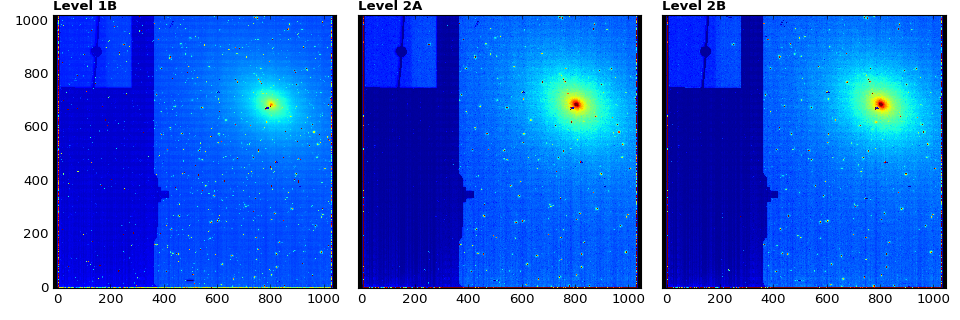

In [12]:
# open the input and output image as jwst data models
with datamodels.open(input_file) as lvl1b_dm:
    with datamodels.open(level2A_file) as lvl2a_dm:
            with datamodels.open(level2B_file) as lvl2b_dm:

                # plot--------------------------------------
                # show the input ramp image and the calibrated
                # slope image.
                %matplotlib notebook
                fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

                # 1B image
                axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.0e4,vmax=1.3e4))
                axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[0].set_axis_bgcolor('black')
                
                # 2A image
                axs[1].imshow(lvl2a_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=30)
                axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[1].set_axis_bgcolor('black')
                
                # 2B image
                axs[2].imshow(lvl2b_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=30)
                axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[2].set_axis_bgcolor('black')

                plt.tight_layout()
                plt.show()